In [1]:
from data_loader import extract_pair
from backtest import estimate_gamma_ols, compute_spread, backtest_pair
from simulation import simulate_model1_paths
from optimize_rules import grid_search_UL
from strategies import strategy_A_signals, strategy_B_signals, strategy_C_signals
from kalman_model1 import fit_kf_model1
from plots import plot_spread_with_signals
from run_paper_table1 import run_paper_table1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Fichier pour lancer tout dans l'ordre (inspire de comme run_optimize_UL)

Avant de commencer, activer le venv avec "source bin/activate" dans le bash, ensuite "pip install -r requirements.txt".

Verifier bien que le jupyter il est lui aussi connecte au venv

# 1. Data and pair construction

In [2]:
df = pd.read_excel("dataGQ.xlsx")

pair = extract_pair(df, "PEP US Equity", "KO US Equity")
pair = pair.loc["2012-01-03":"2019-06-28"]

#On les mets en log 
PA = np.log(pair["PA"])
PB = np.log(pair["PB"])

gamma = estimate_gamma_ols(PA, PB)
spread_ols = compute_spread(PA, PB, gamma)

print("Sample:", pair.index.min(), "->", pair.index.max(), pair.shape)
print("gamma:", gamma)

SIM_T = 1000
N_PATHS = 2000
U_SIGMA_GRID = np.arange(0.0, 1.25 + 1e-9, 0.1)  # [0, 1.25] step 0.1
L_SIGMA_GRID = np.arange(-2.5, -0.1 + 1e-9, 0.1)  # [-2.5, -0.1] step 0.1
SEED = 1
TC_BPS_PER_ASSET = 20

Sample: 2012-01-03 00:00:00 -> 2019-06-28 00:00:00 (1884, 2)
gamma: 1.9963928806288074


# 2. Filtering the spread
Ici, pour commencer, je vais implementer un filtre de Kalman standard (pas le QMC)

On commence avec le fit qui prend y = spread ols

In [3]:
y = spread_ols.copy()
kf_res = fit_kf_model1(y, verbose=True)
x_hat = kf_res.x_filt  # filtered latent spread

KF Model I fit:
  theta0 = -0.04704457256734011
  theta1 = 0.9838471533799242
  q      = 0.00018634381657336137
  r      = 5.7607722128556206e-06
  loglik = 5361.427103275161


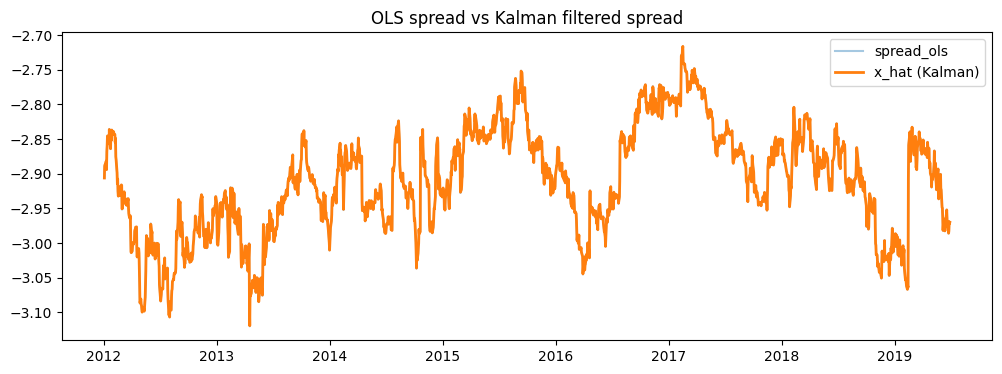

In [4]:
plt.figure(figsize=(12,4))
plt.plot(y.index, y, alpha=0.4, label="spread_ols")
plt.plot(x_hat.index, x_hat, lw=2, label="x_hat (Kalman)")
plt.legend()
plt.title("OLS spread vs Kalman filtered spread")
plt.show()

In [5]:
vy = y.var()
print("theta1", kf_res.params.theta1)
print("q/var(y)", kf_res.params.q / vy)
print("r/var(y)", kf_res.params.r / vy)
print("q/r", kf_res.params.q / kf_res.params.r)


theta1 0.9838471533799242
q/var(y) 0.03232985111791403
r/var(y) 0.0009994692144373674
q/r 32.34702044936273


On trouve que notre x_hat qui est egal ou presque a y. Chat me dit que cela n'est pas une erreur en soi mais plutot que le spread observe est quasi sans bruit. Il me propose des petits modifs sur le filtre de kalman / mettr eun floor sur r mais je ne suis pas sur pour l'instnat.

# 3. Parameter esitmation

Pour cette partie, j'ai retravaille legeremnet le fichier simulation.py


In [6]:
p = kf_res.params
SEED = 1
C_opt = p.theta0 / (1.0 - p.theta1)
sd_opt = np.sqrt(p.q / (1.0 - p.theta1**2))
x_paths = simulate_model1_paths(
    theta0=p.theta0,
    theta1=p.theta1,
    q=p.q,
    r=None,                     # latent only
    n_steps=252,                # 1 an
    n_paths=300,               # Monte Carlo, je mets 300 pour que ca tourne vite quand je fais des tests
    x0=x_hat.iloc[-1],          # dernier état filtré
    seed=SEED
)

# 4. Benchmark trading strategies


In [7]:
U_grid = C_opt + sd_opt * U_SIGMA_GRID
L_grid = C_opt + sd_opt * L_SIGMA_GRID

best_A = grid_search_UL(x_paths, strategy="A", C=C_opt, U_grid=U_grid, L_grid=L_grid, objective="SR")
best_B = grid_search_UL(x_paths, strategy="B", C=C_opt, U_grid=U_grid, L_grid=L_grid, objective="SR")
best_C = grid_search_UL(x_paths, strategy="C", C=C_opt, U_grid=U_grid, L_grid=L_grid, objective="SR")

Real PnL A (x_hat rules): 0.4482212426711667
Real PnL B (x_hat rules): 1.0522057217798002
Real PnL C (x_hat rules): -1.0706891369000118


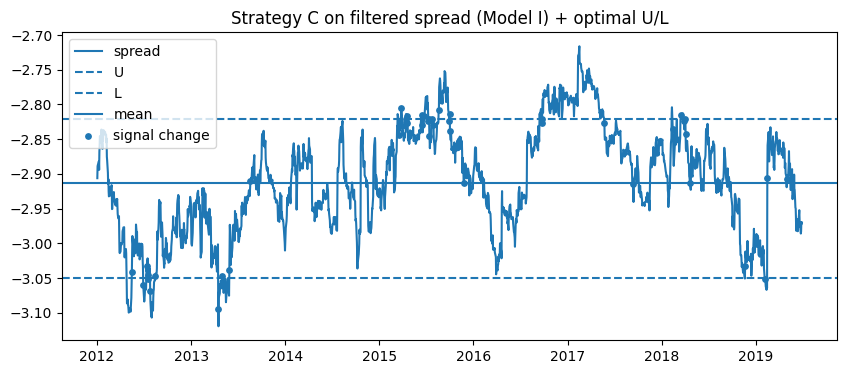

In [8]:
sig_A = strategy_A_signals(x_hat, U=best_A["U"], L=best_A["L"], C=C_opt)
sig_B = strategy_B_signals(x_hat, U=best_B["U"], L=best_B["L"])
sig_C = strategy_C_signals(x_hat, U=best_C["U"], L=best_C["L"], C=C_opt)

bt_A = backtest_pair(PA, PB, gamma, sig_A, tc_bps=20)
bt_B = backtest_pair(PA, PB, gamma, sig_B, tc_bps=20)
bt_C = backtest_pair(PA, PB, gamma, sig_C, tc_bps=20)

print("Real PnL A (x_hat rules):", bt_A["cum_pnl_net"].iloc[-1])
print("Real PnL B (x_hat rules):", bt_B["cum_pnl_net"].iloc[-1])
print("Real PnL C (x_hat rules):", bt_C["cum_pnl_net"].iloc[-1])

# -----------------------------
# 5) Plot (Model I + optimal U/L, Strategy C)
# -----------------------------
plot_spread_with_signals(
    x_hat,
    best_C["U"],
    best_C["L"],
    C_opt,
    sig_C,
    "Strategy C on filtered spread (Model I) + optimal U/L"
)

Bon ici, le fichier run_optimize_UL est deja fait. Je passe a voir comment je fais pour la table 1


# Table 1
En gros on va que faire le modele 1-3 car 4 et 5 on ne peut pas les estimer sur les donnees a cause de la version simple du KF qu'on a.

In [ ]:
df = run_paper_table1(T=1000, N=2000, seed=1)   # debug
df
#Apres optimisation, dfwf

,Model,Strategy,U*_CR,L*_CR,CR,U*_SR,L*_SR,SR
0,Model 1,A,1.0,-1.0,0.291426,1.4,-1.4,0.083103
1,Model 1,B,0.8,-0.8,0.357950,0.8,-0.8,0.074167
2,Model 1,C,2.3,-2.3,0.045909,2.4,-2.4,0.030465
3,Model 2,A,1.1,-1.1,0.368057,1.4,-1.4,0.108896
4,Model 2,B,0.8,-0.9,0.485353,0.8,-0.9,0.100482
5,Model 2,C,2.3,-2.3,0.053023,2.5,-2.5,0.038018
6,Model 3,A,0.1,-0.1,3.742446,0.2,-0.2,0.073526
7,Model 3,B,0.1,-0.1,3.878996,0.1,-0.1,0.072343
8,Model 3,C,0.9,-0.9,0.579649,1.1,-1.3,0.033726
